In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import cPickle
import matplotlib.pyplot as plt
import os

from scipy.interpolate import pchip_interpolate
from scipy.signal import savgol_filter
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz

from bokeh.layouts import gridplot, column
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource,LinearAxis, Range1d
from bokeh.models.glyphs import Text
from bokeh.io import export_png, export_svgs


import seaborn as sns

np.set_printoptions(threshold=np.inf)

In [2]:
def jump_stitcher_anyMetric(incorrectVar, plot_flag):
    incorrectVar_diff = np.diff(incorrectVar)
    if incorrectVar_diff.size:
        diff_cutoff = np.percentile(incorrectVar_diff, 99)*10;

        out_of_bound_max_cutoff = np.percentile(incorrectVar,99)+(np.percentile(incorrectVar,99)-np.percentile(incorrectVar,1))/2
        out_of_bound_min_cutoff = np.percentile(incorrectVar,1)-(np.percentile(incorrectVar,99)-np.percentile(incorrectVar,1))/2

        out_of_bound_index = np.where((incorrectVar>out_of_bound_max_cutoff) | (incorrectVar<out_of_bound_min_cutoff))
        out_of_bound_index = np.asarray(out_of_bound_index).flatten()
        discontinuity_index = np.array([-1])

        for i in range(0, len(incorrectVar_diff)):
            if np.abs(incorrectVar_diff[i]) > diff_cutoff:
                discontinuity_index = [discontinuity_index, (i-1), i, (i+1)]

        discontinuity_index = np.unique(discontinuity_index[discontinuity_index > 0])

        incorrectVar_nan = incorrectVar
        incorrectVar_nan[np.union1d(out_of_bound_index,discontinuity_index)] = np.nan
#         correctedVar = pd.Series(incorrectVar_nan).interpolate(method='pchip').ffill().bfill().as_matrix()
        correctedVar = pd.Series(incorrectVar_nan).interpolate(method='linear').as_matrix()        
#         correctedVar = pchip_interpolate(np.arange(0, len(incorrectVar_nan)), 
#                                          incorrectVar_nan, np.arange(0, len(incorrectVar_nan)))

        if plot_flag == 1:
            fig = plt.figure(figsize=(15, 8))
            plt.plot(np.arange(0, len(incorrectVar_nan[1000:1300])), incorrectVar_nan[1000:1300], color='k')
            plt.plot(np.arange(0, len(correctedVar[1000:1300])), 2+correctedVar[1000:1300], 'r')
            plt.show()
    else:
        correctedVar = incorrectVar

    return correctedVar

def calculateTailSpeed(tailposition, tf, history):
    tailSpeed = np.zeros((np.shape(tailposition)[0],), dtype=np.float)
    tailDisplacement = np.zeros((np.shape(tailposition)[0],), dtype=np.float)
    x = (tailposition[history:, 0] - tailposition[:-history, 0])**2
    y = (tailposition[history:, 1] - tailposition[:-history, 1])**2
    tailDisplacement[history:] = np.sqrt(x + y).copy()
    tailDisplacement = jump_stitcher_anyMetric(tailDisplacement, 0)
    tailSpeed[history:] = tailDisplacement[history:]/np.asarray(history*tf, dtype=np.float)
    tailSpeed = jump_stitcher_anyMetric(tailSpeed, 0)
    return tailSpeed

def smoothen_savgol(dat, window_size, polyOrder):
    dat_filt = savgol_filter(dat, window_size, polyOrder, mode='nearest')
    return dat_filt

def smoothen_convolve(dat, window):
    dat_filt = np.convolve(dat, window, mode='same')
    return dat_filt

def smoothen_gaussian(dat, window_size, sigma):
    b = gaussian(window_size, sigma)
    dat_filt = np.convolve(dat, b/b.sum(), mode='same')
    return dat_filt

def smoothen_gaussian_past(dat, window_size, sigma):
    b = gaussian(window_size, sigma)
    b = b/b.sum()
    b[window_size/2:] = 0
    dat_filt = np.convolve(dat, b, mode='same')
    return dat_filt

def get_stimulus_start_end(stimulus, baseline):
    stim_diff = stimulus - baseline
    stim_diff_2 = np.where(stim_diff > 0)[0]
    stim_diff_3 = np.where(np.ediff1d(stim_diff_2, to_begin=2000) > 1)[0]
    start = stim_diff_2[stim_diff_3]
    end = stim_diff_2[stim_diff_3-1]
    end = np.roll(end, -1)
    inter_start = np.hstack((0, end+5))
    inter_end = np.hstack((start-5, len(stimulus)))
    return start, end, inter_start, inter_end

def calculate_deltaF_by_F(before_val, after_val):
    return np.divide((after_val - before_val), before_val)

def convert_stimulus_percent_to_watts(stim):
    conv = lambda x: -6*(10**-5)*(x**3) - 0.0007*(x**2) + 0.9577*x - 1.4352
    stim_converted = conv(stim)
    return stim_converted

In [3]:
## CsChrimson Experiment
start_frame = 250
end_frame = 33000

experiment, is_tail = '20180321_OK371_CsChrimson_Midpoint_DoseResponse_200micron', False
# experiment, is_tail = '20180322_OK371_CsChrimson_Tail_DoseResponse_600micron', True

# experiment, is_tail = '20180320_Cha_CsChrimson_Midpoint_DoseResponse_200micron', False
# experiment, is_tail = '20180323_Cha_CsChrimson_Tail_DoseResponse_600micron', True

# experiment, is_tail = '20180402_8113_CsChrimson_Midpoint_DoseResponse_200micron', False
# experiment, is_tail = '20180402_8113_CsChrimson_Tail_DoseResponse_600micron', True

# experiment, is_tail = '20180402_221_CsChrimson_Midpoint_DoseResponse_600micron', False
# experiment, is_tail = '20180403_221_CsChrimson_Tail_DoseResponse_1000micron', True

# experiment, is_tail = '20180404_8113_CsChrimson_Midpoint_DoseResponse_600micron', False
# experiment, is_tail = '20180404_8113_CsChrimson_Tail_DoseResponse_1000micron', True

# experiment, is_tail = '20180408_Clh8_221_CsChrimson_Midpoint_DoseResponse_600micron', False
# experiment, is_tail = '20180408_Clh8_221_CsChrimson_Tail_DoseResponse_1000micron', True

# experiment, is_tail = '20180408_Clh8_221_CsChrimson_Midpoint_DoseResponse_600micron', False
# experiment, is_tail = '20180408_Clh8_221_CsChrimson_Tail_DoseResponse_600micron', True

# experiment, is_tail = '20180429_BG57_Midpoint_600micron', False
# experiment, is_tail = '20180429_BG57_Tail_1000micron', True

if is_tail == True:
    trend_color = "slateblue"
else:
    trend_color = "green"
    
## Load Data
load_data = 1
if load_data > 0:
    data_dir = os.path.join('../../../Data/', experiment, 'XML')
    kin_data_all = pd.read_csv(os.path.join(data_dir, 'kinData_xml.dat'), sep='\t', low_memory=False)
    fig_dir = os.path.join('../../../Figures/', experiment)
    if os.path.exists(fig_dir) != True:
        os.mkdir(fig_dir)

In [4]:
## Extract Tail Speed Logged by Tracker
all_tail_speed_tracker = kin_data_all.loc[:,['tailSpeed', 'num', 'timeIndex']].pivot(index='num', columns='timeIndex').as_matrix()[:,start_frame:end_frame]

In [5]:
## Extract Tail Positions
all_tail_position = []
all_tail_position_x = kin_data_all.loc[:,['tail_x', 'num', 'timeIndex']].pivot(index='num', columns='timeIndex').as_matrix()[:,start_frame:end_frame]
all_tail_position_y = kin_data_all.loc[:,['tail_y', 'num', 'timeIndex']].pivot(index='num', columns='timeIndex').as_matrix()[:,start_frame:end_frame]
num_animals = np.shape(all_tail_position_x)[0]

In [6]:
## Time per frame (in seconds)
tf = 0.008
total_time = np.arange(start_frame,end_frame)*tf
baseline = 0
stimulus = kin_data_all['intensity'][start_frame:end_frame].values
stimulus_watts = convert_stimulus_percent_to_watts(stimulus.copy())

In [7]:
## Compute Tail Speed
## For Savgol
window = 63
polyOrder = 5

## Parameters Gaussian Filter
window_size = 10
sigma = 1

all_tail_speed = np.zeros_like(all_tail_position_x)
all_tail_speed_filtered = np.zeros_like(all_tail_position_x)
for i in range(0, np.shape(all_tail_position_x)[0]):
    temp_pos = np.array([all_tail_position_x[i, :], all_tail_position_y[i, :]], dtype=np.float16).T
    temp_speed = calculateTailSpeed(temp_pos, tf, window)
    all_tail_speed[i,:] = temp_speed
    all_tail_speed_filtered[i, :] = smoothen_savgol(temp_speed, window, polyOrder)
#     all_tail_speed_filtered[i, :] = smoothen_gaussian_past(all_tail_speed[i,:].copy(), window_size, sigma)

/Users/ajinkyadeogade/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/ajinkyadeogade/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Users/ajinkyadeogade/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


In [8]:
## Compute Mean Tail Speed
mean_tail_speed = np.nanmean(all_tail_speed, axis=0)
mean_tail_speed_filtered = np.nanmean(all_tail_speed_filtered, axis=0)

In [9]:
## Create a Trendline for Mean Tail Speed
window_size = 250
sigma = 125
mean_tail_speed_trendline = smoothen_gaussian(mean_tail_speed.copy(), window_size, sigma)
# mean_tail_speed_trendline = smoothen_gaussian(mean_tail_speed_filtered.copy(), window_size, sigma)

In [22]:
## Visualize Mean Tail Speed for All Larva
# p1 = figure(x_axis_type="linear", title=experiment, 
#             plot_width=1600, plot_height=600, y_range=(0, 2.5),
#            toolbar_location="above")
p1 = figure(x_axis_type="linear", 
            plot_width=1600, plot_height=600,
            y_range=(0, 2.5), toolbar_location=None)

# p1.grid.grid_line_alpha=0.3
p1.background_fill_color = None
p1.border_fill_color = None

p1.xaxis.axis_label = 'Time (sec)'
p1.yaxis.axis_label = 'Tail speed (mm/sec)'
p1.line(total_time, mean_tail_speed, 
        legend='Tail Speed', color='gray', line_alpha= 0.25)
p1.line(total_time, mean_tail_speed_trendline, 
        legend='Tail Speed Trendline', color=trend_color, line_width=3)
p1.xaxis.ticker = [0, 60, 120, 180, 240]
p1.yaxis.ticker = [0, 1, 2]

# Setting the second y axis range name and range
p1.extra_y_ranges = {"Stimulus": Range1d(start=-3, end=52)}
p1.add_layout(LinearAxis(y_range_name="Stimulus", 
                         axis_label="Stimulus W/m^2", 
                         ticker=[0, 25, 50], axis_label_standoff=40), 'right')
p1.line(total_time, stimulus_watts, legend='Stimulus',
        y_range_name='Stimulus', color='crimson')

# Dummy Glyph to add legend for the number of animals
p1.circle(1, 1, color='white', legend='N = %d'%(num_animals))
p1.yaxis.axis_label_standoff=30

p1.xaxis.axis_label_text_font_size = "24pt"
p1.yaxis.axis_label_text_font_size = "24pt"

p1.xaxis.major_label_text_font_size = "18pt"
p1.yaxis.major_label_text_font_size = "18pt"

p1.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks
p1.yaxis.minor_tick_line_color = None  # turn off y-axis minor ticks

p1.xaxis.axis_line_width = 2
p1.yaxis.axis_line_width = 2

p1.xaxis.major_tick_line_width = 2
p1.yaxis.major_tick_line_width = 2

p1.legend.location = "top_right"
p1.legend.glyph_width = 30
p1.legend.label_text_font_size = "16pt"

p1.xgrid.grid_line_color = None
p1.ygrid.grid_line_color = None

output_file(os.path.join(fig_dir, "001_mean_tail_speed_%s.html"%(experiment)), title=experiment)
show(p1)  # open a browser

export_png(p1, os.path.join(fig_dir, "001_mean_tail_speed_%s.png"%(experiment)))

p1.output_backend = "svg"
export_svgs(p1, filename=os.path.join(fig_dir, "001_mean_tail_speed_%s.svg"%(experiment)))

OSError: [Errno 9] Bad file descriptor

In [11]:
## Visualize Tail Speed for Individual Larva 
visualize = 0
if visualize > 0:
    p1 = figure(x_axis_type="linear", title=experiment, 
                plot_width=1600, plot_height=600, y_range=(0, 5),
               toolbar_location="above")
    p1.grid.grid_line_alpha=0.3

    larva = 0

    p1.xaxis.axis_label = 'Time (sec)'
    p1.yaxis.axis_label = 'Tail speed (mm/sec)'
    p1.line(total_time, all_tail_speed_filtered[larva,:], 
            legend='Tail Speed Filtered', color='red', line_alpha= 0.5)
    p1.line(total_time, all_tail_speed[larva,:], 
            legend='Tail Speed Raw', color='gray', line_alpha= 0.5)
#     p1.line(total_time, all_tail_speed_tracker[larva,:], 
#         legend='Tail Speed Tracker', color='green', line_alpha= 0.5)

    p1.xaxis.axis_label_text_font_size = "18pt"
    p1.yaxis.axis_label_text_font_size = "18pt"

    p1.xaxis.major_label_text_font_size = "14pt"
    p1.yaxis.major_label_text_font_size = "14pt"

    p1.legend.location = "top_right"
    output_file("005_indv_tail_speed_%s.html"%(experiment), title="meanTailSpeed")
    show(p1)  # open a browser

In [12]:
stim_start, stim_end, stim_inter_start, stim_inter_end = get_stimulus_start_end(stimulus, baseline)

mean_tail_speed_flash = np.zeros((np.shape(all_tail_speed)[0], 3*len(stim_start)))
for i in range(0, np.shape(all_tail_speed)[0]):
    for j in range(0, len(stim_start)):
        mean_tail_speed_flash[i, 3*j] =  np.nanmean(all_tail_speed[i, stim_start[j]-380:stim_start[j]-5])
        mean_tail_speed_flash[i, 3*j+1] =  np.nanmean(all_tail_speed[i, stim_start[j]:stim_end[j]+500])
        mean_tail_speed_flash[i, 3*j+2] =  np.nanmean(all_tail_speed[i, stim_end[j]+501:stim_end[j]+1000])

/Users/ajinkyadeogade/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in greater


In [27]:
qmin = np.nanpercentile(mean_tail_speed_flash, 0, axis=0)
q1 = np.nanpercentile(mean_tail_speed_flash, 25, axis=0)
q2 = np.nanpercentile(mean_tail_speed_flash, 50, axis=0)
q3 = np.nanpercentile(mean_tail_speed_flash, 75, axis=0)
qmax = np.nanpercentile(mean_tail_speed_flash, 100, axis=0)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr
mean_of_means = np.nanmean(mean_tail_speed_flash, axis=0)
std_of_means = np.nanstd(mean_tail_speed_flash, axis=0)

upper = [min([x,y]) for (x,y) in zip(list(qmax), upper)]
lower = [max([x,y]) for (x,y) in zip(list(qmin), lower)]

'/Volumes/GoogleDrive/My Drive/CRG_Dropbox/AljoComputer/Matlab/high_res_tracker/Figures/20180321_OK371_CsChrimson_Midpoint_DoseResponse_200micron/002_boxplot_tail_speed_20180321_OK371_CsChrimson_Midpoint_DoseResponse_200micron.png'

In [88]:
# cats = np.sort(np.hstack((np.arange(2, 3*3, 2.5), 
#                           np.arange(2.4, 3*3, 2.5),
#                           np.arange(2.8, 3*3, 2.5))))

cats_1 = np.array([2, 2.4, 2.8])
cats_3 = np.hstack((cats_1, cats_1 + 2, cats_1 + 4.4))

cats = np.hstack((cats_3, cats_3 + 7, cats_3 + 14, cats_3 + 21))

p = figure(plot_width=1600, plot_height=200, y_range=(-0.1, 2.1),
           x_range=(-1, max(cats)+1), toolbar_location=None)

p.background_fill_color = None
p.border_fill_color = None

# stems
p.segment(cats, lower, cats, q1, line_color="black")
p.segment(cats, upper, cats, q3, line_color="black")

# # boxes
bef = np.arange(0,len(cats),3)
dur = np.arange(1,len(cats),3)
aft = np.arange(2,len(cats),3)
p.vbar(cats[bef], 0.3, q1[bef], q2[bef], fill_color="lightgray", line_color="black")
p.vbar(cats[bef], 0.3, q2[bef], q3[bef], fill_color="lightgray", line_color="black")
p.vbar(cats[dur], 0.3, q1[dur], q2[dur], fill_color="red", line_color="black")
p.vbar(cats[dur], 0.3, q2[dur], q3[dur], fill_color="red", line_color="black")
p.vbar(cats[aft], 0.3, q1[aft], q2[aft], fill_color="gray", line_color="black")
p.vbar(cats[aft], 0.3, q2[aft], q3[aft], fill_color="gray", line_color="black")

# whiskers (almost-0 height rects simpler than segments)
p.rect(cats, lower, 0.2, 0.01, line_color="black")
p.rect(cats, upper, 0.2, 0.01, line_color="black")

p.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks
p.yaxis.minor_tick_line_color = None  # turn off y-axis minor ticks

p.xaxis.axis_line_width = 0
p.yaxis.axis_line_width = 2

p.xaxis.major_tick_line_width = 0
p.yaxis.major_tick_line_width = 2

# p1.legend.location = "top_right"
# p1.legend.glyph_width = 30
# p1.legend.label_text_font_size = "16pt"

p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

p.xaxis.visible = None
p.yaxis.axis_label = 'Tail speed (mm/sec)'
p.yaxis.ticker = [0, 1, 2]

p.yaxis.axis_label_text_font_size = "16pt"
p.yaxis.major_label_text_font_size = "18pt"
p.yaxis.axis_label_standoff=30

output_file(os.path.join(fig_dir, "002_boxplot_tail_speed_%s.html"%(experiment)), title=experiment)
show(p)

export_png(p, os.path.join(fig_dir, "002_boxplot_tail_speed_%s.png"%(experiment)))
# p1.output_backend = "svg"
# export_svgs(p, filename=os.path.join(fig_dir, "002_boxplot_tail_speed_%s.svg"%(experiment)))

'/Volumes/GoogleDrive/My Drive/CRG_Dropbox/AljoComputer/Matlab/high_res_tracker/Figures/20180321_OK371_CsChrimson_Midpoint_DoseResponse_200micron/002_boxplot_tail_speed_20180321_OK371_CsChrimson_Midpoint_DoseResponse_200micron.png'

In [14]:
mean_tail_speed_flash_before = np.zeros((np.shape(all_tail_speed)[0], len(stim_start)))
mean_tail_speed_flash_after = np.zeros((np.shape(all_tail_speed)[0], len(stim_start)))

min_tail_speed_flash_before = np.zeros((np.shape(all_tail_speed)[0], len(stim_start)))
min_tail_speed_flash_after = np.zeros((np.shape(all_tail_speed)[0], len(stim_start)))
deltaF_by_F_tail_speed = np.zeros((np.shape(all_tail_speed)[0], len(stim_start)))
for i in range(0, np.shape(all_tail_speed)[0]):
    for j in range(0, len(stim_start)):
        mean_tail_speed_flash_before[i, j] =  np.nanmean(all_tail_speed[i, stim_start[j]-380:stim_start[j]-5], axis=0)
        mean_tail_speed_flash_after[i, j] =  np.nanmean(all_tail_speed[i, stim_start[j]:stim_end[j]+500], axis=0)
        deltaF_by_F_tail_speed[i, j] = calculate_deltaF_by_F(mean_tail_speed_flash_before[i, j], mean_tail_speed_flash_after[i, j])
mean_deltaF_by_F_tail_speed = np.nanmean(deltaF_by_F_tail_speed, axis=0)
median_deltaF_by_F_tail_speed = np.nanmedian(deltaF_by_F_tail_speed, axis=0)
# plt.bar(np.arange(0,len(median_deltaF_by_F_tail_speed)), mean_deltaF_by_F_tail_speed)

/Users/ajinkyadeogade/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in divide


In [15]:
step_dur_2 = np.arange(0, 11, 3)
step_dur_4 = step_dur_2 + 1
step_dur_8 = step_dur_2 + 2

step_inten_8 = np.array([0, 1, 2])
step_inten_16 = step_inten_8 + 3
step_inten_24 = step_inten_8 + 6
step_inten_32 = step_inten_8 + 9

In [16]:
mean_tail_speed_before = pd.DataFrame(mean_tail_speed_flash_before.T)
mean_tail_speed_before['Stimulus Duration (sec)'] = 0
mean_tail_speed_before['Stimulus Intensity (W/m^2)'] = 0
mean_tail_speed_before['Condition'] = 'Before Stimulus' ## pre -> before

mean_tail_speed_before.loc[step_dur_2, 'Stimulus Duration (sec)'] = 2
mean_tail_speed_before.loc[step_dur_4, 'Stimulus Duration (sec)'] = 4
mean_tail_speed_before.loc[step_dur_8, 'Stimulus Duration (sec)'] = 8

mean_tail_speed_before.loc[step_inten_8, 'Stimulus Intensity (W/m^2)'] = 8
mean_tail_speed_before.loc[step_inten_16, 'Stimulus Intensity (W/m^2)'] = 16
mean_tail_speed_before.loc[step_inten_24, 'Stimulus Intensity (W/m^2)'] = 24
mean_tail_speed_before.loc[step_inten_32, 'Stimulus Intensity (W/m^2)'] = 32

In [17]:
mean_tail_speed_after = pd.DataFrame(mean_tail_speed_flash_after.T)
mean_tail_speed_after['Stimulus Duration (sec)'] = 0
mean_tail_speed_after['Stimulus Intensity (W/m^2)'] = 0
mean_tail_speed_after['Condition'] = 'During Stimulus' ## post -> after

mean_tail_speed_after.loc[step_dur_2, 'Stimulus Duration (sec)'] = 2
mean_tail_speed_after.loc[step_dur_4, 'Stimulus Duration (sec)'] = 4
mean_tail_speed_after.loc[step_dur_8, 'Stimulus Duration (sec)'] = 8

mean_tail_speed_after.loc[step_inten_8, 'Stimulus Intensity (W/m^2)'] = 8
mean_tail_speed_after.loc[step_inten_16, 'Stimulus Intensity (W/m^2)'] = 16
mean_tail_speed_after.loc[step_inten_24, 'Stimulus Intensity (W/m^2)'] = 24
mean_tail_speed_after.loc[step_inten_32, 'Stimulus Intensity (W/m^2)'] = 32

In [18]:
mean_tail_speed_before_after = pd.concat([mean_tail_speed_before, mean_tail_speed_after], axis=0)
mean_tail_speed_before_after = mean_tail_speed_before_after.melt(id_vars=['Stimulus Duration (sec)', 
                                                                          'Stimulus Intensity (W/m^2)', 
                                                                          'Condition'], 
                                                                 value_name='Tail Speed (mm/sec)')
mean_tail_speed_before_after.drop('variable', axis=1, inplace=True)

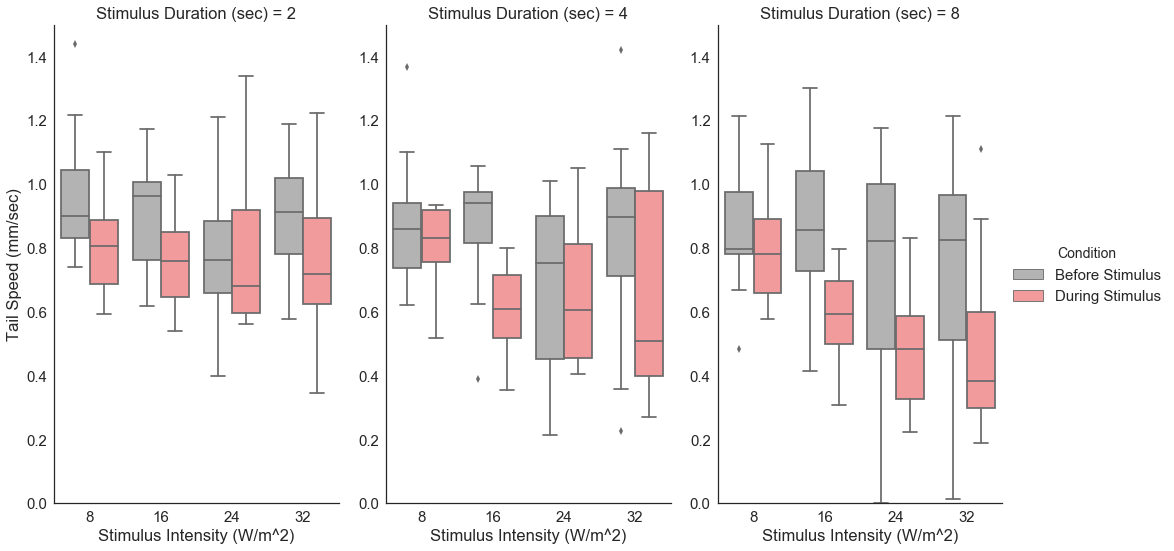

In [19]:
sns.set_context("notebook", font_scale=1.5)
sns.set_style("white")

g = sns.factorplot(x="Stimulus Intensity (W/m^2)", y="Tail Speed (mm/sec)",
                   hue="Condition", col="Stimulus Duration (sec)",
                   data=mean_tail_speed_before_after, kind="box", size=8, aspect=.6,
                   palette={"Before Stimulus": [0.7, 0.7, 0.7], "During Stimulus": [1, 0.55, 0.56]});
plt.ylim(0, 1.5);
plt.savefig(os.path.join(fig_dir, "003_factor_plot_flash_duration_tail_speed_%s.png"%(experiment)))

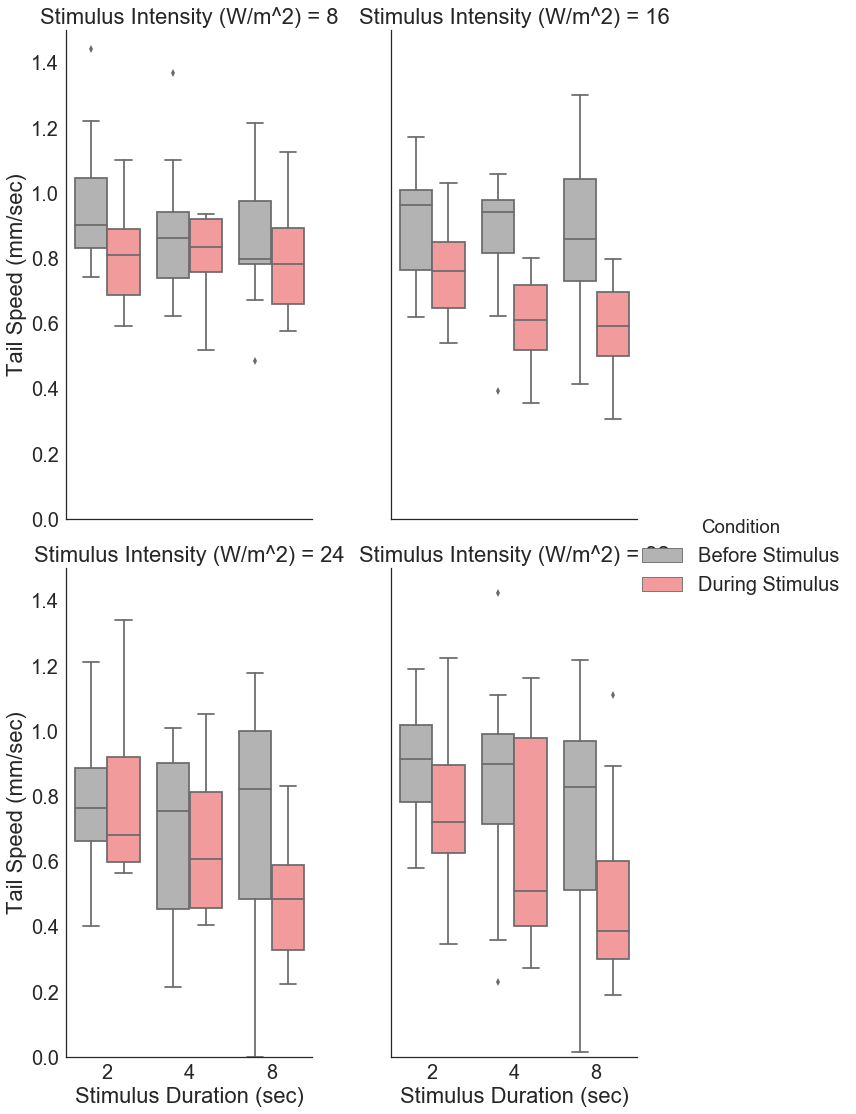

In [20]:
sns.set_context("notebook", font_scale=2)
sns.set_style("white")

g = sns.factorplot(x="Stimulus Duration (sec)", y="Tail Speed (mm/sec)",
                   hue="Condition", col="Stimulus Intensity (W/m^2)", col_wrap=2,
                   data=mean_tail_speed_before_after, kind="box", size=8, aspect=.6,
                   palette={"Before Stimulus": [0.7, 0.7, 0.7], "During Stimulus": [1, 0.55, 0.56]});
plt.ylim(0, 1.5);
plt.savefig(os.path.join(fig_dir, "004_factor_plot_flash_intensity_tail_speed_%s.png"%(experiment)))

In [21]:
# def get_boxplot(df, group, plot_y_metric):
#     # find the quartiles and IQR for each category
#     groups = df.groupby(group)
#     q1 = groups.quantile(q=0.25)
#     q2 = groups.quantile(q=0.5)
#     q3 = groups.quantile(q=0.75)
#     iqr = q3 - q1
#     upper = q3 + 1.5*iqr
#     lower = q1 - 1.5*iqr
    
#     # find the outliers for each category
#     def outliers(group, plot_y_metric):
#         cat = group.name
#         return group[(group.loc[:, plot_y_metric] > upper.loc[cat, plot_y_metric]) | 
#                      (group.loc[:, plot_y_metric] < lower.loc[cat, plot_y_metric])][plot_y_metric]
#     out = groups.apply(lambda x: outliers(x, plot_y_metric)).dropna()
    
#     # prepare outlier data for plotting, we need coordinates for every outlier.
#     cats = groups.groups.keys()
#     if not out.empty:
#         outx = []
#         outy = []
#         for cat in cats:
#             # only add outliers if they exist
#             if not out.loc[cat].empty:
#                 for value in out[cat]:
#                     outx.append(cat)
#                     outy.append(value)
    
#     p = figure(tools="save", background_fill_color="#EFE8E2", title="", x_range=cats)
    
#     # if no outliers, shrink lengths of stems to be no longer than the minimums or maximums
#     qmin = groups.quantile(q=0.00)
#     qmax = groups.quantile(q=1.00)
#     upper.loc[:,plot_y_metric] = [min([x,y]) for (x,y) in zip(list(qmax.loc[:, plot_y_metric]), upper.loc[:,plot_y_metric])]
#     lower.loc[:,plot_y_metric] = [max([x,y]) for (x,y) in zip(list(qmin.loc[:, plot_y_metric]), lower.loc[:,plot_y_metric])]

#     # stems
#     p.segment([cats[1]], upper.loc[[cats[1]],plot_y_metric], [cats[1]], q3.loc[[cats[1]],plot_y_metric], line_color="black")
#     p.segment([cats[0]], upper.loc[[cats[0]],plot_y_metric], [cats[0]], q3.loc[[cats[0]],plot_y_metric], line_color="black")
#     p.segment([cats[1]], lower.loc[[cats[1]],plot_y_metric], [cats[1]], q1.loc[[cats[1]],plot_y_metric], line_color="black")
#     p.segment([cats[0]], lower.loc[[cats[0]],plot_y_metric], [cats[0]], q1.loc[[cats[0]],plot_y_metric], line_color="black")
    
#     # boxes
#     p.vbar([cats[1]], 0.3, q1.loc[[cats[1]],plot_y_metric], q3.loc[[cats[1]],plot_y_metric], fill_color="gray", line_color="black")
#     p.vbar([cats[0]], 0.3, q1.loc[[cats[0]],plot_y_metric], q3.loc[[cats[0]],plot_y_metric], fill_color="red", line_color="black")    

#     # whiskers (almost-0 height rects simpler than segments)
#     p.rect([cats[1]], lower.loc[[cats[1]],plot_y_metric], 0.2, 0.01, line_color="black")
#     p.rect([cats[0]], lower.loc[[cats[0]],plot_y_metric], 0.2, 0.01, line_color="black")
#     p.rect([cats[1]], upper.loc[[cats[1]],plot_y_metric], 0.2, 0.01, line_color="black")
#     p.rect([cats[0]], upper.loc[[cats[0]],plot_y_metric], 0.2, 0.01, line_color="black")    

#     # outliers
#     if not out.empty:
#         p.circle(outx, outy, size=6, color="#F38630", fill_alpha=0.6)

#     p.xgrid.grid_line_color = None
#     p.ygrid.grid_line_color = "white"
#     p.grid.grid_line_width = 2
#     p.xaxis.major_label_text_font_size="12pt"

#     output_file("boxplot.html", title="boxplot.py example")

#     show(p)

# get_boxplot(mean_tail_speed_before_after, 'Condition', 'Tail Speed (mm/sec)')